In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from ipywidgets import interact, fixed
import ipywidgets as widgets
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import random
import torch.nn.functional as F

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

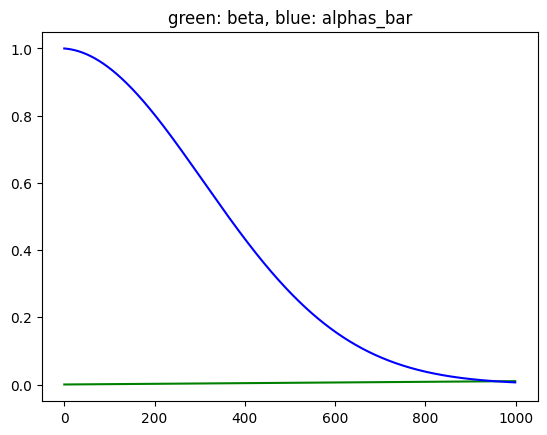

In [4]:
n_step = 1000
beta_start = 0.0001
beta_end = 0.01
scale = 1000 / n_step # T = 1000 ->. scale = 1

betas = torch.linspace(beta_start * scale, beta_end * scale, n_step)
alphas = 1 - betas
alphas_bar = torch.cumprod(alphas, dim=0)

plt.plot(betas, 'g')
plt.plot(alphas_bar, 'b')
plt.title('green: beta, blue: alphas_bar')
plt.show()

alphas_bar = alphas_bar.to(device)
betas = betas.to(device)
alphas = alphas.to(device)

In [5]:
def extract(arr, t, x_shape):
    if not torch.is_tensor(t):
        b = 1
        t = torch.tensor(t).to(device)
    else:
        b = t.shape[0]

    out = arr.gather(-1, t) # array의 t번쨰 index를 가져와서 새로운 tensor로 만들어줌
    return out.view((b, ) + (1, ) * (len(x_shape) - 1))

def diffuse_once(x, t):
    return (1 - betas[t]).sqrt() * x + betas[t].sqrt() * torch.randn_like(x)

def diffuse(x, t, eta=None):
    if eta is None:
        eta = torch.randn_like(x).to(device)

    x_t = extract(alphas_bar.sqrt(), t, x.shape) * x + extract((1 - alphas_bar).sqrt(), t, x.shape) * eta

    return x_t

In [7]:
'''
3d UNet
'''

import math

class TimeEmbedding_UNet_CFG(nn.Module):
    def __init__(self, emb_dim: int):
        super().__init__()
        self.emb_dim = emb_dim
        self.lin1 = nn.Linear(self.emb_dim // 4, self.emb_dim)
        self.lin2 = nn.Linear(self.emb_dim, self.emb_dim)
        self.act = nn.SiLU()

    def forward(self, t: torch.Tensor):
        half_dim = self.emb_dim // 8
        emb = math.log(10_000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=1)

        emb = self.act(self.lin1(emb))
        emb = self.lin2(emb)

        return emb
    

class Residual_UNet_CFG(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.SiLU()
        )

        self.time_emb = TimeEmbedding_UNet_CFG(out_channels)

        self.conv2 = nn.Sequential(
            nn.Conv3d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.SiLU()
        )

    def forward(self, x, t):
        x = self.conv1(x)
        t_emb = self.time_emb(t)
        x = self.conv2(x + t_emb[:, :, None, None, None])
        
        return x
    

# 3D Attention Gate 모듈 정의 (encoder의 특징 x와 디코더의 gating signal g를 받아 attention map을 구한 뒤, x에 곱해줌)
class AttentionGate3D_CFG(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()

        self.W_g = nn.Sequential(
            nn.Conv3d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm3d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv3d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm3d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv3d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm3d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, g):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)

        return x * psi
    

class ClassEmbedding_CFG(nn.Module):
    def __init__(self, num_classes: int, emb_dim: int):
        super().__init__()
        self.embedding = nn.Sequential(
            nn.Linear(num_classes, emb_dim),
            nn.SiLU(),
            nn.Linear(emb_dim, emb_dim)
        )

    def forward(self, c):
        return self.embedding(c)


class Unet_CFG(nn.Module):
    def __init__(self, channels: list, n_steps: int, class_num: int):
        super().__init__()

        self.channels = channels
        self.n_steps = n_steps
        self.class_num = class_num

        self.down1 = Residual_UNet_CFG(1, self.channels[0])
        self.down2 = Residual_UNet_CFG(self.channels[0], self.channels[1])
        self.down3 = Residual_UNet_CFG(self.channels[1], self.channels[2])

        self.att_gate1 = AttentionGate3D_CFG(F_g=self.channels[1], F_l=self.channels[0], F_int=self.channels[0] // 2)
        self.att_gate2 = AttentionGate3D_CFG(F_g=self.channels[2], F_l=self.channels[1], F_int=self.channels[1] // 2)

        self.up1 = Residual_UNet_CFG(self.channels[2] + self.channels[1], self.channels[1])
        self.up2 = Residual_UNet_CFG(self.channels[1] + self.channels[0], self.channels[0])

        self.class_emb1 = ClassEmbedding_CFG(self.class_num, self.channels[2])
        self.class_emb2 = ClassEmbedding_CFG(self.class_num, self.channels[1])

        self.upsample1 = nn.ConvTranspose3d(self.channels[2], self.channels[2], kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.upsample2 = nn.ConvTranspose3d(self.channels[1], self.channels[1], kernel_size=(1, 2, 2), stride=(1, 2, 2))

        self.maxpool = nn.MaxPool3d(kernel_size=(1, 2, 2))

        self.final = nn.Sequential(
            nn.Conv3d(self.channels[0] + 1, self.channels[0], 3, padding=1),
            nn.BatchNorm3d(self.channels[0]),
            nn.SiLU(),
            nn.Conv3d(self.channels[0], 1, 3, padding=1)
        )

    def forward(self, x, t, c):
        input_data = x.clone()
        t = t.float() / self.n_steps

        conv1 = self.down1(x, t)
        x = self.maxpool(conv1)

        conv2 = self.down2(x, t)
        x = self.maxpool(conv2)

        x = self.down3(x, t)

        x = self.upsample1(x)     #upsampling

        c_emb1 = self.class_emb1(c)
        x = x * c_emb1[:, :, None, None, None]
        conv2_att = self.att_gate2(conv2, x)
        #print(x.shape)
        #print(c_emb1.shape)
        x = torch.cat([x, conv2_att], dim=1)
        x = self.up1(x, t)

        x = self.upsample2(x)     #upsampling

        c_emb2 = self.class_emb2(c)
        x = x * c_emb2[:, :, None, None, None]
        conv1_att = self.att_gate1(conv1, x)
        x = torch.cat([x, conv1_att], dim=1)
        x = self.up2(x, t)

        x = torch.cat([x, input_data], dim=1)
        x = self.final(x)

        return x

In [36]:
model = Unet_CFG(channels=[128, 192, 256], n_steps=n_step, class_num=7).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=4e-5)
criterion = nn.MSELoss()

print("model parameter size :", sum(p.numel() for p in model.parameters() if p.requires_grad))

model parameter size : 11320295


In [ ]:
class ContinuousMNISTDataset(Dataset):
    def __init__(self, root='./data', train=True, transform=transforms.ToTensor(), download=True, data_size=60000):
        self.mnist = datasets.MNIST(root=root, train=train, download=download, transform=transform)
        self.data_size = data_size
        
        self.label_to_indices = {i: [] for i in range(10)}
        for idx, (_, label) in enumerate(self.mnist):
            self.label_to_indices[label].append(idx)
        
        self.allowed_starts = list(range(7))
    
    def __len__(self):
        return self.data_size

    def __getitem__(self, index):
        start_digit = random.choice(self.allowed_starts)
        images = []
        labels = []
        
        for d in [start_digit, start_digit + 1, start_digit + 2, start_digit + 3]:
            idx = random.choice(self.label_to_indices[d])
            img, label = self.mnist[idx]
            images.append(img)
            labels.append(label)
        
        images = torch.stack(images, dim=0)
        images = images.permute(1, 0, 2, 3)
        #images.squeeze_(0)

        images = (images * 2) - 1
        
        labels = torch.tensor(labels)
        return images, labels

In [38]:
dataset = ContinuousMNISTDataset(data_size=10000)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
print(len(dataloader))

313


Batch: 0
Data shape: torch.Size([32, 1, 4, 28, 28])
Target shape: torch.Size([32, 4])


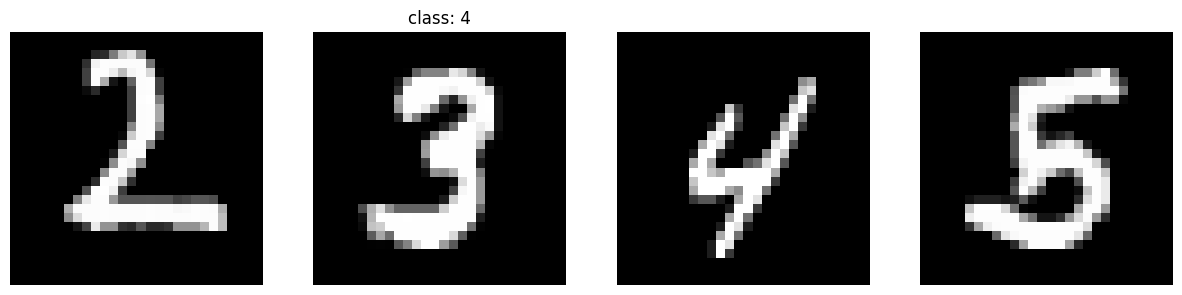

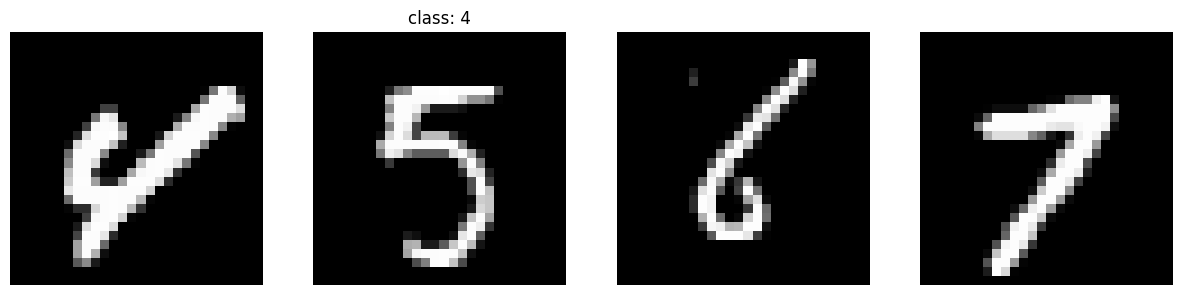

torch.Size([32, 1, 4, 28, 28])


In [41]:
for batch_idx, (data, target) in enumerate(dataloader):
    print('Batch:', batch_idx)
    print('Data shape:', data.shape)    # Expected: (32, 1, 4, 28, 28)
    print('Target shape:', target.shape)  # Expected: (32, 3)

    for i in range(2):
        fig, ax = plt.subplots(1, 4, figsize=(15, 5))
        ax[1].title.set_text('class: %i' % target[j, 0])
        for j in range(4):
            ax[j].imshow(data[i, 0, j], cmap='gray', vmin=-1, vmax=1)
            ax[j].axis('off')
        plt.show()

    out_size = model(data.to(device), torch.arange(data.shape[0]).to(device), torch.zeros((data.shape[0], 7)).to(device)).shape
    print(out_size)
    break

In [42]:
def get_context_mask(c, drop_prob, n_classes=7, device='cpu'):
    c_hot = F.one_hot(c.to(torch.int64), num_classes=n_classes).to(device)
    c_mask = torch.bernoulli(torch.ones_like(c_hot).float() - drop_prob).to(device)
    return c_hot, c_mask

print(get_context_mask(torch.tensor([0, 1, 2, 3, 4, 5, 6]), 0.1))

(tensor([[1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1]]), tensor([[1., 1., 1., 0., 0., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1.],
        [1., 0., 1., 1., 1., 1., 1.],
        [1., 1., 0., 1., 1., 1., 1.],
        [1., 0., 1., 1., 0., 1., 1.],
        [1., 1., 0., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1.]]))


In [55]:
from tqdm import tqdm

num_epochs = 15

model.train()
for epoch in range(num_epochs):
    loader = tqdm(dataloader)
    losses = []

    for step, (data, target) in enumerate(loader):
        data = data.to(device, dtype=torch.float)
        c_hot, c_mask = get_context_mask(target[:, 0], 0.1, 7, device)

        t = torch.randint(0, n_step, size=(data.shape[0], )).to(device)
        eta = torch.randn_like(data).to(device)
        diffused = diffuse(data, t, eta).to(device)

        output = model(diffused, t, c_hot * c_mask)
        loss_value = criterion(output, eta)

        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()

        loader.set_description("step: %i, loss: %.4f" % (step, loss_value.detach().item()))
        losses.append(loss_value.detach().item())

    print("epoch %i final loss: %.6f" % (epoch, np.mean(losses)))

step: 312, loss: 0.0293: 100%|██████████| 313/313 [01:06<00:00,  4.72it/s]


epoch 0 final loss: 0.046361


step: 312, loss: 0.0316: 100%|██████████| 313/313 [01:02<00:00,  5.04it/s]


epoch 1 final loss: 0.045420


step: 312, loss: 0.0539: 100%|██████████| 313/313 [01:02<00:00,  5.01it/s]


epoch 2 final loss: 0.044595


step: 8, loss: 0.0494:   3%|▎         | 9/313 [00:02<01:09,  4.35it/s]


KeyboardInterrupt: 

In [ ]:
def sample(c:torch.tensor, w=1):
    model.eval()
    with torch.no_grad():
        data = torch.randn((c.shape[0], 1, 4, 28, 28)).to(device)

        for t in range(n_step - 1, -1, -1):  #[n_step - 1, 0], t + 1에서 t로
            z = 0

            if t > 0:
                z = torch.randn_like(data)

            sigma_t = torch.sqrt(betas[t])

            c_hot = F.one_hot(c.to(torch.int64), num_classes=7).to(dtype=torch.float, device=device)
            #print(c_hot.shape)
            pred_noise_keep_class = model(data, torch.tensor([t], dtype=torch.int, device=device), c_hot)
            pred_noise_drop_class = model(data, torch.tensor([t], dtype=torch.int, device=device), torch.zeros_like(c_hot))

            pred_noise = (1 + w) * pred_noise_keep_class - w * pred_noise_drop_class

            # update data
            data = (1 / torch.sqrt(alphas[t])) *\
                (data - (1 - alphas[t]) / torch.sqrt(1 - alphas_bar[t]) * pred_noise) +\
                sigma_t * z

        return data

In [57]:
def show_cfg_continous(c:torch.tensor, w):
    data = sample(c=c, w=w).cpu().numpy()

    fig, ax = plt.subplots(c.shape[0], 4, figsize=(12, 4 * c.shape[0]))

    for i in range(c.shape[0]):
        ax[i, 1].set_title('class: %i, w: %i' % (c[i].item(), w), size=35)
        for j in range(4):
            ax[i, j].imshow(data[i, 0, j], cmap='gray', vmin=-1, vmax=1)
            ax[i, j].axis('off')
    plt.show()

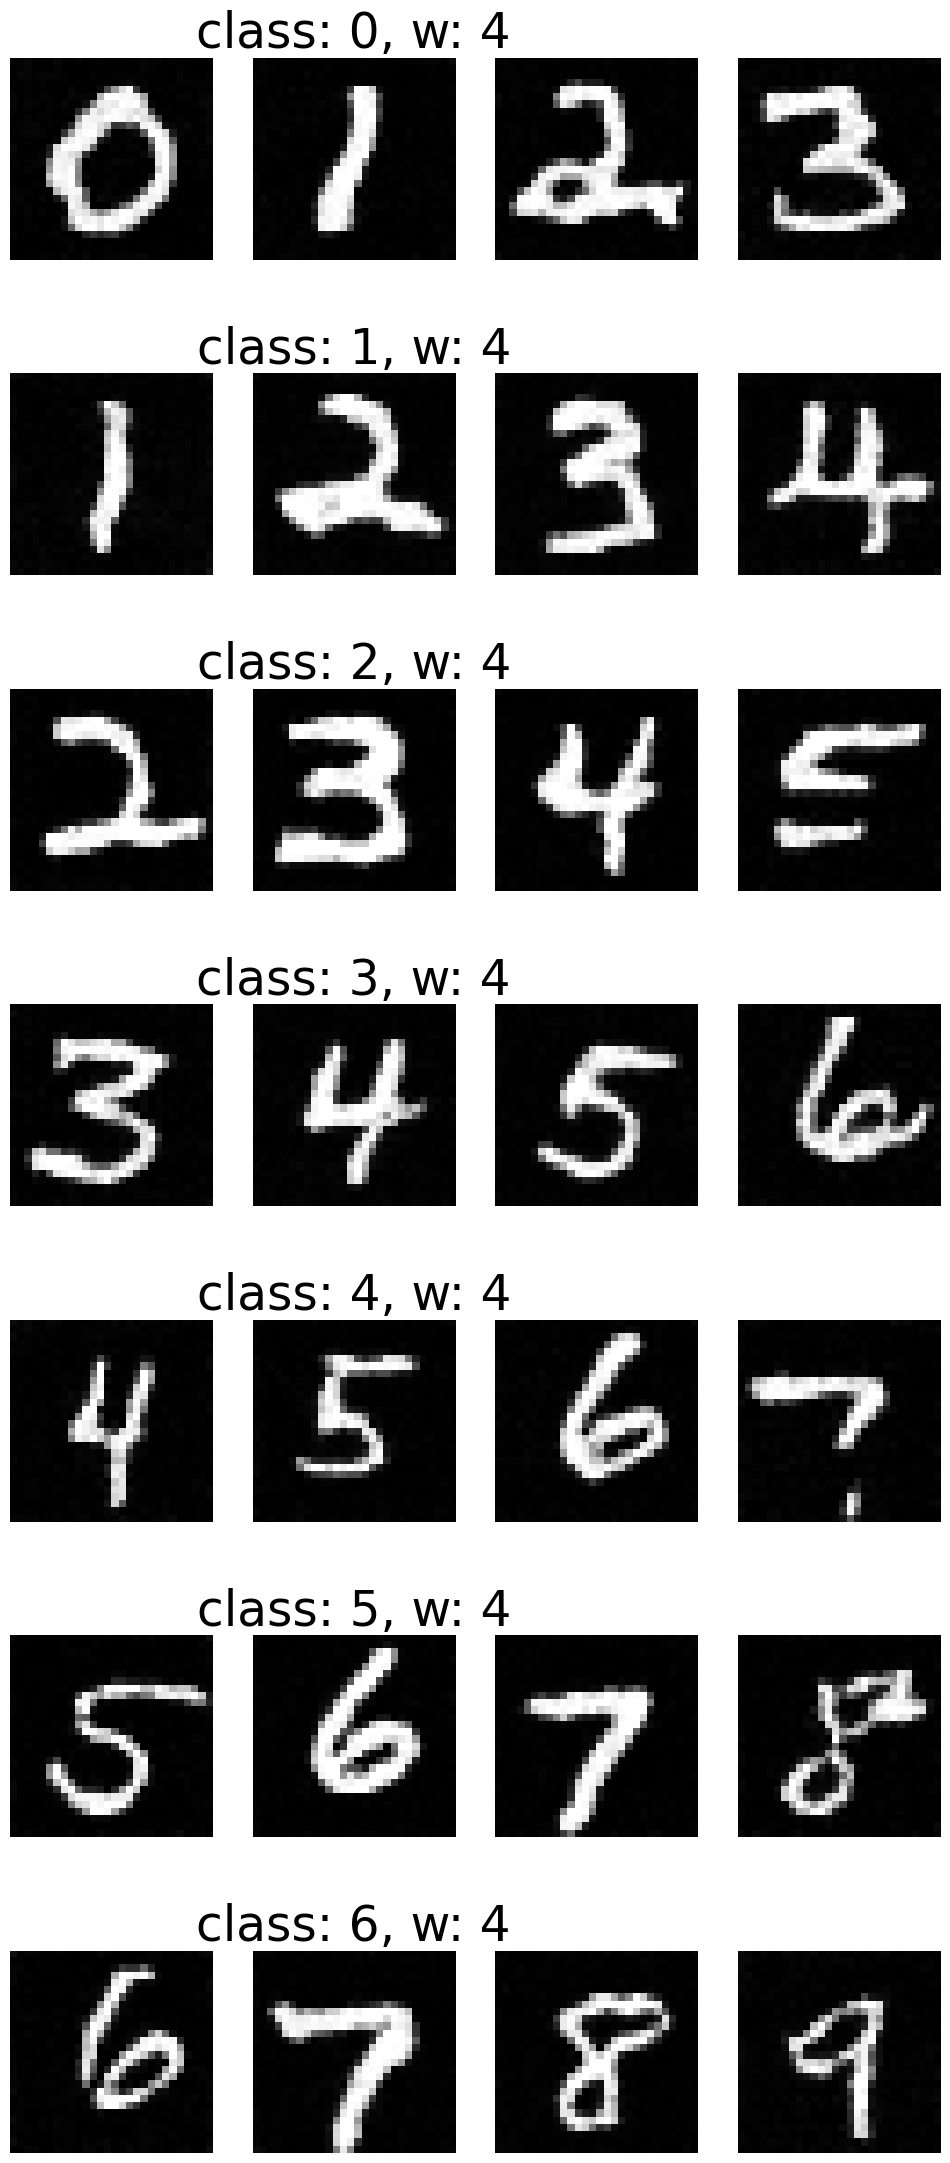

In [58]:
show_cfg_continous(torch.arange(7), 4)

In [43]:
print(data.shape)

torch.Size([0])


In [ ]:
#torch.save(model, 'cfg_3d_unet.nn')

In [21]:
model.load_state_dict(torch.load('cfg_3d_unet.nn').state_dict())

C:\Users\DW21\AppData\Local\Temp\ipykernel_17480\1155087958.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('cfg_3d_unet.nn').state_dict

<All keys matched successfully>